# Point Cloud Dataset Example: Creation and Basic Features

**Boris Slautin**

01/17/2024

**Please download this example and run it as a notebook by scrolling to the
bottom of this page**

In [1]:
# Ensure python 3 compatibility:
from __future__ import division, print_function, absolute_import, unicode_literals
%matplotlib widget

import numpy as np
import sys
sys.path.insert(0,'../../')
import sidpy

print(sidpy.__version__)

0.12.6


## 0. Data Preparation
To begin, we'll generate a seed dataset to convert into the point cloud we can use for experimentation and visualization.

In [2]:
#create a basic spectra and coordinate np.arrays
spectrum_length = 150
num_points = 20

spectra = np.zeros((spectrum_length, num_points))

x = np.random.uniform(0,10,num_points)
for i in range(spectrum_length):
    amplitude = np.sin(i * np.pi / spectrum_length) + 1.5  # Varying amplitude
    center = 5 + np.sin(i * 2 * np.pi / spectrum_length)  # Oscillating center
    width = 1 + 0.5 * np.cos(i * np.pi / spectrum_length)  # Modulated width
    spectra[i] = amplitude * np.exp(-((x - center) ** 2) / (2 * width ** 2))
spectra = spectra.T

print('Spectra array shape: ', spectra.shape)

#Let's create some coordinate points
coordinates = np.random.uniform(-10, 10, (num_points, 2))
print('Coordinate array shape: ', coordinates.shape)

Spectra array shape:  (20, 150)
Coordinate array shape:  (20, 2)


## 1. Creating basic point_cloud dataset

Point Clouds can be represented by the 2D ``sidpy Dataset`` with one ``point_cloud`` dimension and one ``spectral`` dimension or by the 3D ``sidpy Dataset`` with one more ``channel`` dimension. 

A ``point_cloud`` dimension represents point number, while the real points coordinates must be stored in the ``sidpy.Dataset.point_cloud``. To customize spatial units and quantities for specific coordinates, simply extend the ``sidpy.Dataset.point_cloud`` dictionary with the relevant values.

**Option 1: with datatype specifying in ``sidpy.Dataset.from_array``**


In this approach, dimension types are assigned automatically based on their position:

1st dimension (dim=0) → ``POINT_CLOUD`` (Spatial coordinates)\
2nd dimension (dim=1) → ``SPECTRUM`` (Spectral data)\
3rd dimension (dim=2, if present) → ``CHANNEL`` (Multi-channel data)

In [24]:
dset = sidpy.Dataset.from_array(spectra, 
                                datatype = 'point_cloud',  #specify point_cloud datatype
                                coordinates = coordinates, #necessery
                                quantity = 'Intensity',    #optional
                                units = 'a.u.'             #optional
                               )

#spectral dimension quantity and units
dset.dim_1.quantity = 'X'
dset.dim_1.units = 'a.u.'

#specify units and quantity of the point coordinates
dset.point_cloud['spacial_units'] = 'um' 
dset.point_cloud['quantity'] = 'Distance'
print(dset)

sidpy.Dataset of type POINT_CLOUD with:
 dask.array<array, shape=(20, 150), dtype=float64, chunksize=(20, 150), chunktype=numpy.ndarray>
 data contains: Intensity (a.u.)
 and Dimensions: 
a:  generic (generic) of size (20,)
b:  X (a.u.) of size (150,)


**Option 2: Manual**


In this approach, no automatic datatype assignment is performed in ``sidpy.Dataset.from_array``.\
Instead, the dimension types must be manually set after dataset creation.


In [34]:
dset = sidpy.Dataset.from_array(spectra, coordinates = coordinates) #do not specify datatype here

dset.data_type = 'point_cloud'

#specify units and quantity of the point coordinates
dset.point_cloud['spacial_units'] = 'um' 
dset.point_cloud['quantity'] = 'Distance'

#specify dimentions parameters
dset.set_dimension(0, sidpy.Dimension(np.arange(spectra.shape[0]),
                                    name='point number',
                                    quantity='Point number',
                                    dimension_type='point_cloud'))

dset.set_dimension(1, sidpy.Dimension(np.arange(spectra.shape[1]),
                                    name='X',
                                    units='a.u.',
                                    quantity='X',
                                    dimension_type='spectral'))

#specify spectral units and quantity 
dset.units = 'a.u.'
dset.quantity = 'Intensity'

print(dset)

sidpy.Dataset of type POINT_CLOUD with:
 dask.array<array, shape=(20, 150), dtype=float64, chunksize=(20, 150), chunktype=numpy.ndarray>
 data contains: Intensity (a.u.)
 and Dimensions: 
point number:  Point number (generic) of size (20,)
X:  X (a.u.) of size (150,)


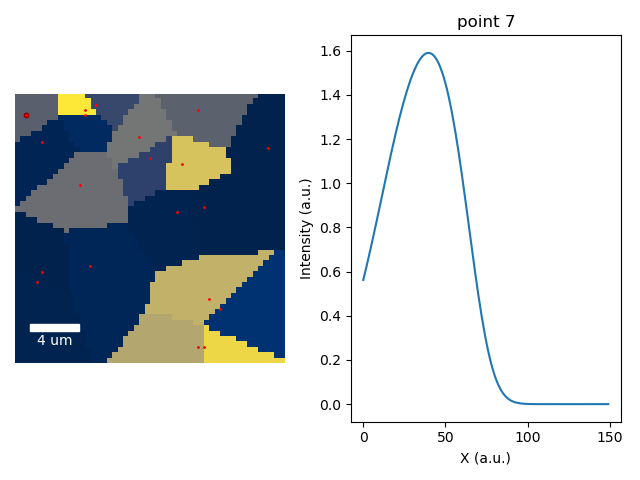

In [35]:
#basic visualization
dset.plot(scale_bar=True, cmap='cividis');

This is an interactive plot. Click on a point to display its corresponding spectrum on the right side of the figure.\
You can customize most figure parameters by specifying attributes in the same way as with a standard Matplotlib plot.

## 2. Advanced options

### 2.1. Variance 

Let's create an additional array to represent the variance. This array must have the same shape as the *spectra* array to ensure element-wise correspondence.

In [48]:
variance = np.random.normal(0.3, 0.1, size=(num_points, spectrum_length))

You can attribute the variance array to the point_cloud dataset at any time. Just ensure that the variance array has the same shape as your dataset for consistency.

In [49]:
print('dset shape: ', dset.shape, '\nvariance array shape: ', variance.shape)

dset shape:  (20, 150) 
variance array shape:  (20, 150)


In [51]:
#adding variance array to the point_cloud dataset
dset.variance = variance

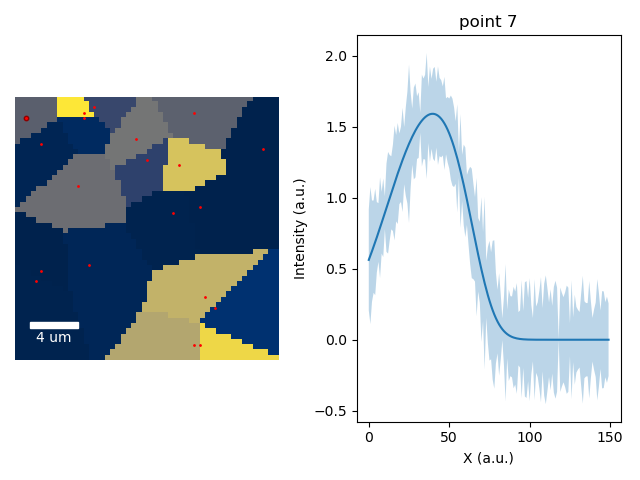

In [52]:
dset.plot(scale_bar=True, cmap='cividis');

### 2.2. Base image

To visualize a point cloud within the real field of view, you can use the dset.plot function by providing an additional attribute called base_name. In this case, you can call the function as follows: ``dset.plot(base_name=image_dataset)``, where image_dataset should be an instance of ``sidpy.Dataset`` with a data_type set to 'IMAGE'.

In [68]:
#create additional dataset to represent field of view 

# some funny pattern
x = np.linspace(-3*np.pi, 3*np.pi, 512)
y = np.linspace(-3*np.pi, 3*np.pi, 512)
X, Y = np.meshgrid(x, y)

im_data = (4 * np.abs(np.cos(X) + np.cos(Y)) +
           3 * np.sin(np.sqrt(X**2 + Y**2)) +  
           2 * np.cos(3*X) * np.cos(3*Y) +  
           np.random.normal(0, 0.3, size=(512, 512)))  

#image dataset creation
image_dataset = sidpy.Dataset.from_array(im_data, datatype='image', units='counts', quantity='intensity')
image_dataset.title = 'random'
image_dataset.set_dimension(0, sidpy.Dimension(np.linspace(-10, 10, image_dataset.shape[0]), 'x'))
image_dataset.x.dimension_type = 'spatial'
image_dataset.x.units = 'um'
image_dataset.x.quantity = 'distance'
image_dataset.set_dimension(1, sidpy.Dimension(np.linspace(-10, 10, image_dataset.shape[1]), 'y'))
image_dataset.y.dimension_type = 'spatial'
image_dataset.y.units = 'um'
image_dataset.y.quantity = 'distance'

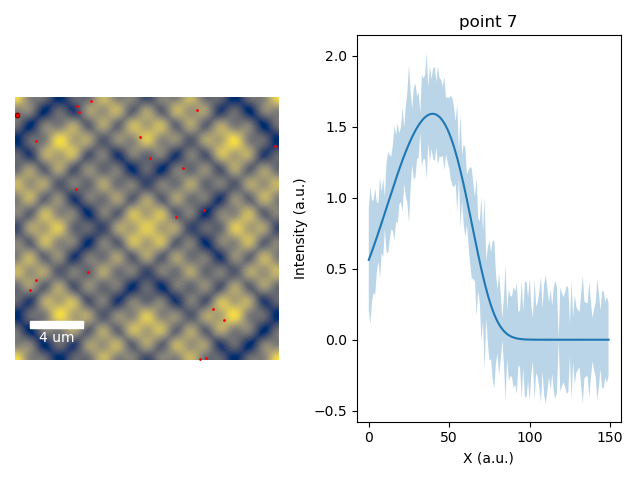

In [70]:
dset.plot(scale_bar=True, cmap='cividis', base_image=image_dataset);